## Luminaire
Table of Contents
* Section 1: Stock time series

*

### Section 1: Stock time series

[*********************100%***********************]  1 of 1 completed


,raw
Date,
2018-01-02,253.283142
2018-01-03,254.885162
2018-01-04,255.959488
2018-01-05,257.665283
2018-01-08,258.136414


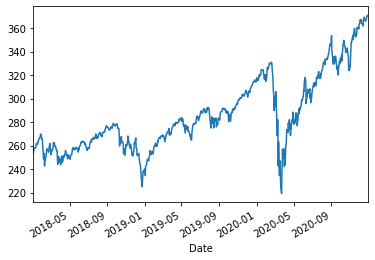

In [227]:
#! pip install yfinance
import pandas as pd
import yfinance as yf
spy = yf.download("SPY", start="2018-01-01", end="2020-12-31")
spy['Adj Close'].plot()
data = pd.DataFrame({'raw': spy['Adj Close']})
data.head()

### Section 2: Luminaire

In [228]:
#pip install luminaire
import luminaire

In [229]:
from luminaire.model.window_density import WindowDensityHyperParams, WindowDensityModel
from luminaire.exploration.data_exploration import DataExploration

In [256]:
config = WindowDensityHyperParams().params
de = DataExploration(freq='D',
                 fill_rate=0.01,
                 is_log_transformed = True
                    )
data2, process_summary = de.profile(df=data)  #stream_profile(df=data)
data2['smoothed'] = np.exp(data2['interpolated'])
data2

,raw,interpolated,smoothed
2020-11-05,347.614868,5.853968,348.614868
2020-11-06,347.535461,5.853740,348.535461
2020-11-07,NaN,5.854579,348.828003
2020-11-08,NaN,5.858825,350.312213
2020-11-09,351.902496,5.866192,352.902496
2020-11-10,351.386383,5.864728,352.386383
2020-11-11,353.996674,5.872108,354.996674
2020-11-12,350.562592,5.862388,351.562592
2020-11-13,355.415955,5.876098,356.415955
2020-11-14,NaN,5.875857,356.329735


In [257]:
config = WindowDensityHyperParams().params
de = DataExploration(freq='D',
                 fill_rate=0.01
                 #is_log_transformed = True
                    )
data2, process_summary = de.profile(df=data)  #stream_profile(df=data)
#data2['smoothed'] = np.exp(data2['interpolated'])
data2

,raw,interpolated
2020-11-05,347.614868,347.614868
2020-11-06,347.535461,347.535461
2020-11-07,NaN,347.828003
2020-11-08,NaN,349.312213
2020-11-09,351.902496,351.902496
2020-11-10,351.386383,351.386383
2020-11-11,353.996674,353.996674
2020-11-12,350.562592,350.562592
2020-11-13,355.415955,355.415955
2020-11-14,NaN,355.329735


In [248]:
data.shape

(755, 1)

In [249]:
data2.shape

(56, 2)

In [250]:
data2.head()

,raw,interpolated
2020-11-05,347.614868,5.853968
2020-11-06,347.535461,5.853740
2020-11-07,NaN,5.854579
2020-11-08,NaN,5.858825
2020-11-09,351.902496,5.866192


* It interpolates the missing data according to the date
* It keeps the minimum 

In [251]:
print(process_summary)

{'success': True, 'trend_change_list': ['2018-04-03 00:00:00', '2018-04-24 00:00:00', '2018-08-07 00:00:00', '2018-10-23 00:00:00', '2018-11-20 00:00:00', '2019-02-05 00:00:00', '2019-03-05 00:00:00', '2019-04-09 00:00:00', '2019-05-21 00:00:00', '2019-07-30 00:00:00', '2019-08-20 00:00:00', '2019-10-22 00:00:00', '2019-12-24 00:00:00', '2020-02-18 00:00:00', '2020-03-03 00:00:00', '2020-05-05 00:00:00', '2020-05-26 00:00:00', '2020-07-21 00:00:00', '2020-09-08 00:00:00', '2020-10-13 00:00:00'], 'change_point_list': ['2018-07-09 00:00:00', '2018-08-24 00:00:00', '2019-01-31 00:00:00', '2019-04-01 00:00:00', '2019-04-23 00:00:00', '2019-06-18 00:00:00', '2020-02-27 00:00:00', '2020-04-08 00:00:00', '2020-11-05 00:00:00'], 'is_log_transformed': True, 'min_ts_mean': None, 'ts_start': '2018-01-02 00:00:00', 'ts_end': '2020-12-30 00:00:00'}


In [ ]:
# https://github.com/zillow/luminaire/blob/master/luminaire/exploration/data_exploration.py